In [18]:
from langgraph.graph import StateGraph,START,END
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel,schema,Field
from typing import TypedDict,Annotated,Literal
import operator

In [19]:
llm = ChatOllama(
    model='qwen2:7b'
)

In [20]:
class Sentiment(BaseModel):

    sentiment:Literal["Positive","Negative"] = Field(description='Sentiment of review')

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [21]:
llm_str = llm.with_structured_output(Sentiment)
llm_str2 = llm.with_structured_output(DiagnosisSchema)

In [22]:
class Review(TypedDict):
    review:str
    sentiment:Literal['Positive','Negative']
    diagnosis:dict
    response:str

In [23]:
def find_sentiment(state:Review):
    prompt = f'for the following review find out the sentiment \n {state['review']}'
    Sentiment=llm_str.invoke(prompt).sentiment

    return {'sentiment':Sentiment}

def check_sentiment(state:Review)->Literal['positive_response','run_diagnosis']:
    if state['sentiment']=='Positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: Review):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = llm.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: Review):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = llm_str2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: Review):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm.invoke(prompt).content

    return {'response': response}
    

In [24]:
graph = StateGraph(Review)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('negative_response',negative_response)
graph.add_node('run_diagnosis',run_diagnosis)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)

graph.add_edge('positive_response',END)

graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

workflow=graph.compile()


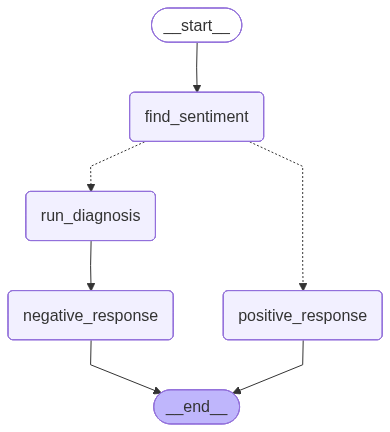

In [25]:
workflow

In [26]:
review="""I rarely write negative reviews, but my experience with this product was extremely disappointing. From the beginning, the quality did not match the description provided. The material felt cheap, and the overall build seemed fragile and poorly finished.

The performance was equally underwhelming. It did not function as expected and often lagged or stopped working entirely after short periods of use. I tried following the instructions carefully, but the issues continued. For the price I paid, I expected much better reliability and durability.

Customer service was another major letdown. My queries were either answered very late or not addressed properly. Instead of offering a clear solution, I received generic responses that did not resolve my concerns.

Overall, this purchase did not meet my expectations in terms of quality, functionality, or support. I would not recommend it to others and would advise potential buyers to explore alternative options before making a decision."""

In [27]:
initial_state = {'review':review}

final_state = workflow.invoke(initial_state)

print(final_state)

{'review': 'I rarely write negative reviews, but my experience with this product was extremely disappointing. From the beginning, the quality did not match the description provided. The material felt cheap, and the overall build seemed fragile and poorly finished.\n\nThe performance was equally underwhelming. It did not function as expected and often lagged or stopped working entirely after short periods of use. I tried following the instructions carefully, but the issues continued. For the price I paid, I expected much better reliability and durability.\n\nCustomer service was another major letdown. My queries were either answered very late or not addressed properly. Instead of offering a clear solution, I received generic responses that did not resolve my concerns.\n\nOverall, this purchase did not meet my expectations in terms of quality, functionality, or support. I would not recommend it to others and would advise potential buyers to explore alternative options before making a dec